# Pretrained ConvNext Inference

In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoImageProcessor, ConvNextForImageClassification
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm import tqdm
import copy

[image classification datasets](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=trending)

huggingface dataset hub에서 공유된 데이터셋을 확인할 수 있습니다
image classification에서 유명한 데이터셋 중에 cats, dogs dataset이 있네요 이 데이터셋을 가져와줍시다


In [ ]:
dataset = load_dataset("cats_vs_dogs")

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [ ]:
dataset # train split만 존재하는 데이터셋

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

모델은 facebook에서 배포한 convnext를 가져와줍니다. imagenet 데이터셋으로 학습된 모델이네요.

개와 고양이를 잘 분류할 수 있을겁니다!

[model description](https://huggingface.co/facebook/convnext-tiny-224)



# ConvNext
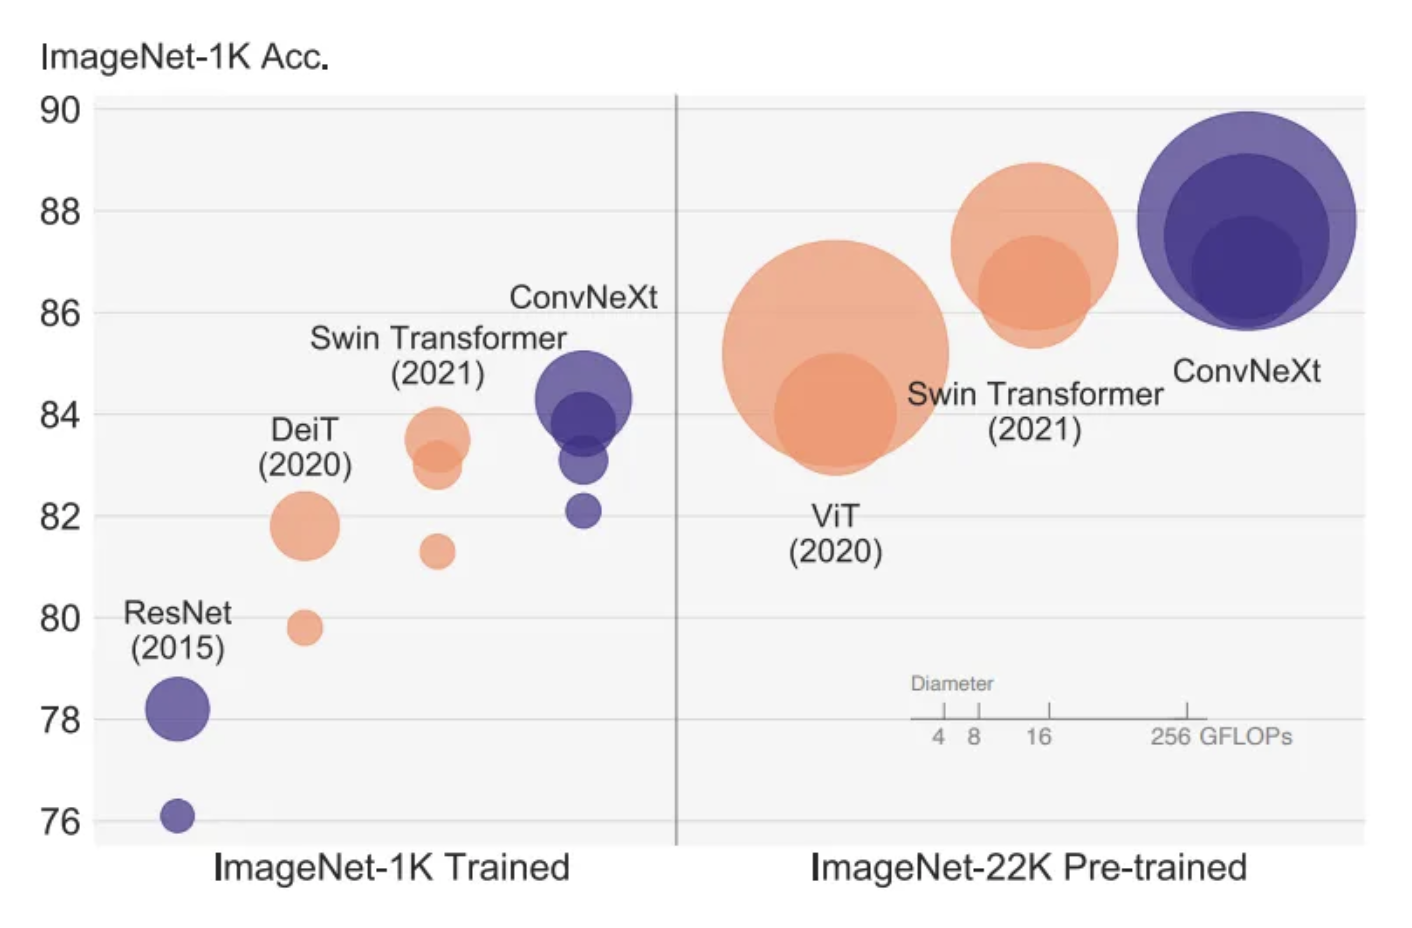
Convnext는 "A ConvNet for the 2020s"에서 제안된 CNN 구조로 CVPR2022에 선정된 비교적 최근 모델입니다.

Convnext는 최신 기법들을 적용해 ResNet-50의 성능을 최대한으로 뽑아낸 모델입니다. 다음의 기법들이 적용되었습니다.

    - ViT (patchify, block 비율 ..)
    - ResNext (grouped convolution)
    - inverted convolution
    - GeLU (ReLU의 변형)
    - label smoothing, stochastic depth 등 최신 학습 기법



In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
dataset = dataset["train"]

In [ ]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'labels': 0}

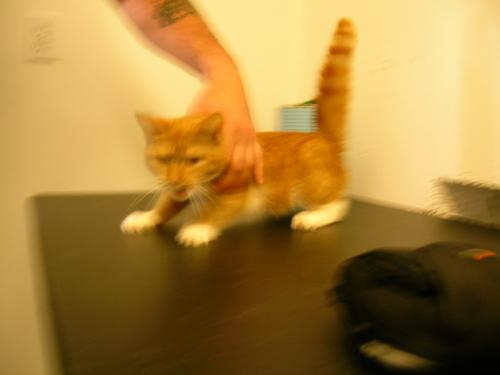

In [ ]:
image = dataset[0]["image"]
image

In [ ]:
inputs = image_processor(image.convert("RGB"), return_tensors="pt")

with torch.no_grad():
    output = model(**inputs) # 딕셔너리를 keyword argument로 unpack 해주는 연산자
    logits = output.logits

predicted_label = logits.argmax(-1).item() # 가장 예측 확률이 높은 인덱스 추출
print(model.config.id2label[predicted_label])

tiger cat


# cats vs dogs dataset으로 image classification 학습시키기

In [ ]:
model.modules

<bound method Module.modules of ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): Co

convnext의 base model과 linear layer를 이어 custom model을 정의해줍니다.

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.base_model = model.base_model
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(768, 2)

    def forward(self, pixel_values):
        output = self.base_model(pixel_values)["pooler_output"]
        output = self.dropout(output)
        output = self.classifier(output)

        return output

In [ ]:
custom_model = CustomModel()
custom_model.modules

<bound method Module.modules of CustomModel(
  (base_model): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()

encoder 역할을 할 base model은 학습시키지 않습니다

In [ ]:
for params in custom_model.base_model.parameters():
    params.requires_grad = False

huggingface에서 제공하는 Dataset 클래스는 pytorch dataloader와 호환이 가능하고 transformation을 정의해줄 수 있습니다. (일종의 augmentation)

사전학습된 이미지 프로세서로 처리하고 device에 맞게 옮기도록 transformation을 정의해줍니다.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def transform(sample):
    sample["image"] = [ image.convert("RGB") for image in sample["image"] ]
    sample["pixel_values"] = image_processor(sample["image"], return_tensors="pt")["pixel_values"].to(device)
    sample["labels"] = torch.tensor(sample["labels"]).to(device)
    del sample["image"]
    return sample

In [ ]:
NUM_EPOCH = 10

dataset.set_transform(transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

custom_model.to(device)
custom_model.train()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(custom_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)

for epoch in range(NUM_EPOCH):
    for i, images in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()

        logits = custom_model(images["pixel_values"])
        labels = images["labels"]
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
    scheduler.step()

    print(f"epoch {epoch+1} loss:", loss.item())

100%|██████████| 732/732 [04:36<00:00,  2.64it/s]


epoch 0 loss: tensor(0.0270, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:42<00:00,  2.59it/s]


epoch 1 loss: tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:25<00:00,  2.75it/s]


epoch 2 loss: tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:28<00:00,  2.73it/s]


epoch 3 loss: tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:26<00:00,  2.74it/s]


epoch 4 loss: tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:26<00:00,  2.75it/s]


epoch 5 loss: tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:24<00:00,  2.76it/s]


epoch 6 loss: tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:26<00:00,  2.75it/s]


epoch 7 loss: tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:27<00:00,  2.74it/s]


epoch 8 loss: tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 732/732 [04:24<00:00,  2.77it/s]

epoch 9 loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward0>)


**inference**

In [ ]:
dataset = load_dataset("cats_vs_dogs")
dataset = dataset["train"]

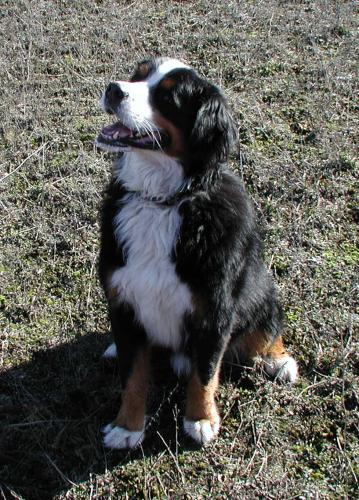

In [ ]:
image = dataset[20000]["image"]
image

In [ ]:
inputs = image_processor(image.convert("RGB"), return_tensors="pt")
inputs.to(device)

with torch.no_grad():
    logits = custom_model(**inputs) # 딕셔너리를 keyword argument로 unpack 해주는 연산자

predicted_label = logits.argmax(-1).item() # 가장 예측 확률이 높은 인덱스 추출

if predicted_label == 0:
    print("cat")
else:
    print("dog")

dog
